## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.FranceConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/')

In [2]:
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## II. Running all datasets of all regions together

In [5]:
# Read in
data_FR = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/csv/FR_wgms_dataset_monthly_full.csv')
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_monthly_full_no_sgi.csv')
data_IT_AT = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/IT_AT/csv/IT_AT_wgms_dataset_monthly_full_with_millanv.csv')
data_NOR = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/csv/NOR_dataset_monthly_full_with_millanv.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_monthly_full_with_hugonnetdhdt.csv')

# Adjust dfs to match
data_FR = data_FR.drop(columns=['GLACIER_ZONE'], errors='ignore')

# Merge all datasets to 1 df
data_combined = pd.concat([data_CH, data_FR, data_IT_AT, data_NOR, data_ICE], axis=0).reset_index(drop=True)
data_combined = data_combined[data_combined['PERIOD'] != 'summer'].reset_index(drop=True)

In [6]:
display(data_combined['GLACIER'].unique())
# Create dataloader for the combined dataset
dataloader_gl = mbm.dataloader.DataLoader(cfg,
                                        data=data_combined,
                                        random_seed=cfg.seed,
                                        meta_data_columns=cfg.metaData)

array(['adler', 'albigna', 'aletsch', 'allalin', 'basodino', 'cantun',
       'chessjen', 'clariden', 'corbassiere', 'corvatsch', 'damma',
       'findelen', 'forno', 'gietro', 'gorner', 'gries', 'hohlaub',
       'joeri', 'limmern', 'morteratsch', 'murtel', 'oberaar', 'otemma',
       'pizol', 'plainemorte', 'plattalva', 'rhone', 'sanktanna',
       'sardona', 'schwarzbach', 'schwarzberg', 'sexrouge', 'silvretta',
       'taelliboden', 'tiefen', 'tortin', 'tsanfleuron', 'vorab',
       'witenwasseren', 'FR4N01235A08 dArgentiere',
       'FR4N01146D09+E06 Gebroulaz', 'FR4N01236A01 Mer de Glace/Geant',
       'FR4N01236A01 Leschaux', 'FR4N01236A07 de Talefre',
       'FR4N01163A02 de Sarennes 1',
       'FR4N01162B09+154D03 de Saint Sorlin',
       'FR4N01236A02 des Grands Montets', 'GOLDBERG K.', 'HINTEREIS F.',
       'JAMTAL F.', 'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.',
       'VERNAGT F.', 'CARESER', 'MALAVALLE (VEDR. DI) / UEBELTALF.',
       'PENDENTE (VEDR.) / HANGENDE

In [7]:
test_glaciers_FR = ['FR4N01146D09+E06 Gebroulaz']

test_glaciers_CH = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'corvatsch', 'tsanfleuron', 'forno'
]

test_glaciers_ICE = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']


test_glaciers_NOR = ['Cainhavarre', 'Rundvassbreen', 'Svartisheibreen', 'Trollbergdalsbreen', 'Hansebreen', 
'Tunsbergdalsbreen', 'Austdalsbreen', 'Hellstugubreen', 'Austre Memurubreen', 'Bondhusbrea', 'Svelgjabreen', 
'Moesevassbrea', 'Blomstoelskardsbreen']

test_glaciers_AT = [
    'GOLDBERG K.', 'HINTEREIS F.', 'JAMTAL F.',
    'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
    'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.'
]

test_glaciers = test_glaciers_FR + test_glaciers_CH + test_glaciers_ICE + test_glaciers_NOR + test_glaciers_AT

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 88583
Size of train data: 441037
Percentage of test size: 20.09%
Train glaciers: (104) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'damma' 'findelen' 'gietro' 'gorner' 'gries'
 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma' 'plainemorte'
 'rhone' 'sardona' 'schwarzbach' 'sexrouge' 'silvretta' 'taelliboden'
 'tiefen' 'vorab' 'witenwasseren' 'FR4N01235A08 dArgentiere'
 'FR4N01236A01 Mer de Glace/Geant' 'FR4N01236A01 Leschaux'
 'FR4N01236A07 de Talefre' 'FR4N01163A02 de Sarennes 1'
 'FR4N01162B09+154D03 de Saint Sorlin' 'FR4N01236A02 des Grands Montets'
 'CARESER' 'MALAVALLE (VEDR. DI) / UEBELTALF.'
 'PENDENTE (VEDR.) / HANGENDERF.' 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.'
 'GRAND ETRET' 'CIARDONEY' 'FONTANA BIANCA / WEISSBRUNNF.'
 'LUNGA (VEDRETTA) / LANGENF.' 'CAMPO SETT.' 'LUPO' 'SURETTA MERIDIONALE'
 'CARESER OCCIDENTALE' 'CARESER ORIENTALE' 'CARESER CENTRALE' 'Engabreen'
 'Aalfotbreen' 'Nigardsbreen' 

In [8]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

### NN

In [9]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 160009
Winter (1): 192475
Original PERIOD column preserved: ['annual' 'winter']


In [ ]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate) + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (352484, 29)
Shape of validation dataset: (88553, 29)
Shape of testing dataset: (88583, 29)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'PERIOD_INDICATOR']


#### Initialize Network

In [9]:
# Open grid_search results
gs_results = pd.read_csv(
        'logs/nn_param_search_progress_2025-06-06.csv').sort_values(
        by='valid_loss', ascending=True)
best_params = gs_results.iloc[0].to_dict()

print('Best parameters from grid search:')
for key, value in best_params.items():
    if key not in ['valid_loss', 'train_loss']:
        print(f"{key}: {value}")

gs_results.head(10)

Best parameters from grid search:
lr: 0.001
batch_size: 128
optimizer: <class 'torch.optim.adam.Adam'>
module__layer0: 32
module__layer1: 64
module__layer2: 64
module__layer3: 32
module__dropout: 0.0
status: success
error: nan


,lr,batch_size,optimizer,module__layer0,module__layer1,module__layer2,module__layer3,module__dropout,valid_loss,status,error
4,0.0010,128,<class 'torch.optim.adam.Adam'>,32,64,64,32,0.0,0.316793,success,NaN
16,0.0010,1024,<class 'torch.optim.adam.Adam'>,128,128,64,32,0.3,0.331599,success,NaN
28,0.0010,128,<class 'torch.optim.adam.Adam'>,64,64,32,32,0.2,0.331612,success,NaN
29,0.0010,256,<class 'torch.optim.adam.Adam'>,32,256,32,16,0.0,0.342470,success,NaN
15,0.0010,512,<class 'torch.optim.adam.Adam'>,128,64,64,16,0.4,0.344084,success,NaN
24,0.0001,128,<class 'torch.optim.adam.Adam'>,128,64,64,16,0.4,0.385212,success,NaN
1,0.0100,256,<class 'torch.optim.adam.Adam'>,128,128,64,16,0.3,0.405088,success,NaN
7,0.0100,512,<class 'torch.optim.adam.Adam'>,64,64,64,16,0.4,0.427814,success,NaN
36,0.0001,512,<class 'torch.optim.adam.Adam'>,64,128,32,32,0.0,0.429291,success,NaN
14,0.0100,128,<class 'torch.optim.sgd.SGD'>,32,256,32,32,0.0,0.442194,success,NaN


In [ ]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=10,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter
def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

custom_params = {
    'lr': 0.001,
    'batch_size': 128,
    'module__layer0': 64,
    'module__layer1': 64,
    'module__layer2': 32,
    'module__layer3': 32,
    'module__dropout': 0.2,
    'optimizer':torch.optim.Adam
}

params = custom_params

args = {
    'module': BiggerNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__layer0': params['module__layer0'],
    'module__layer1': params['module__layer1'],
    'module__layer2': params['module__layer2'],
    'module__layer3': params['module__layer3'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 300,
    'optimizer': params['optimizer'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

In [11]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=10,    # Increase from 10
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,   # Reduced more aggressively (was 0.5)
                              patience=5,   # Reduced patience (was 5)
                              threshold=0.01,  # Reduced threshold (was 0.01)
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter
def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)


custom_params = {
    'lr': 0.001,    # reduced from 0.001
    'batch_size': 128,  # Increased from 128
    'module__layer0': 128,
    'module__layer1': 96,
    'module__layer2': 64,
    'module__layer3': 32,
    'module__dropout': 0.2,
    'optimizer':torch.optim.Adam
}

params = custom_params

args = {
    'module': PeriodSpecificNetBigger,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__hidden_dim_0': params['module__layer0'],
    'module__hidden_dim_1': params['module__layer1'], 
    'module__hidden_dim_2': params['module__layer2'],
    'module__hidden_dim_3': params['module__layer3'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 300,
    'optimizer': params['optimizer'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

#### Create Datasets

In [12]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (24094,) (24094,)
validation: (6024,) (6024,)


#### Train custom model

In [14]:
TRAIN = False
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

else:
    # Load model and set to CPU
    model_filename = "nn_model_2025-07-09.pt"  # Replace with actual date if needed
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

#### Load model and make predictions

In [15]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

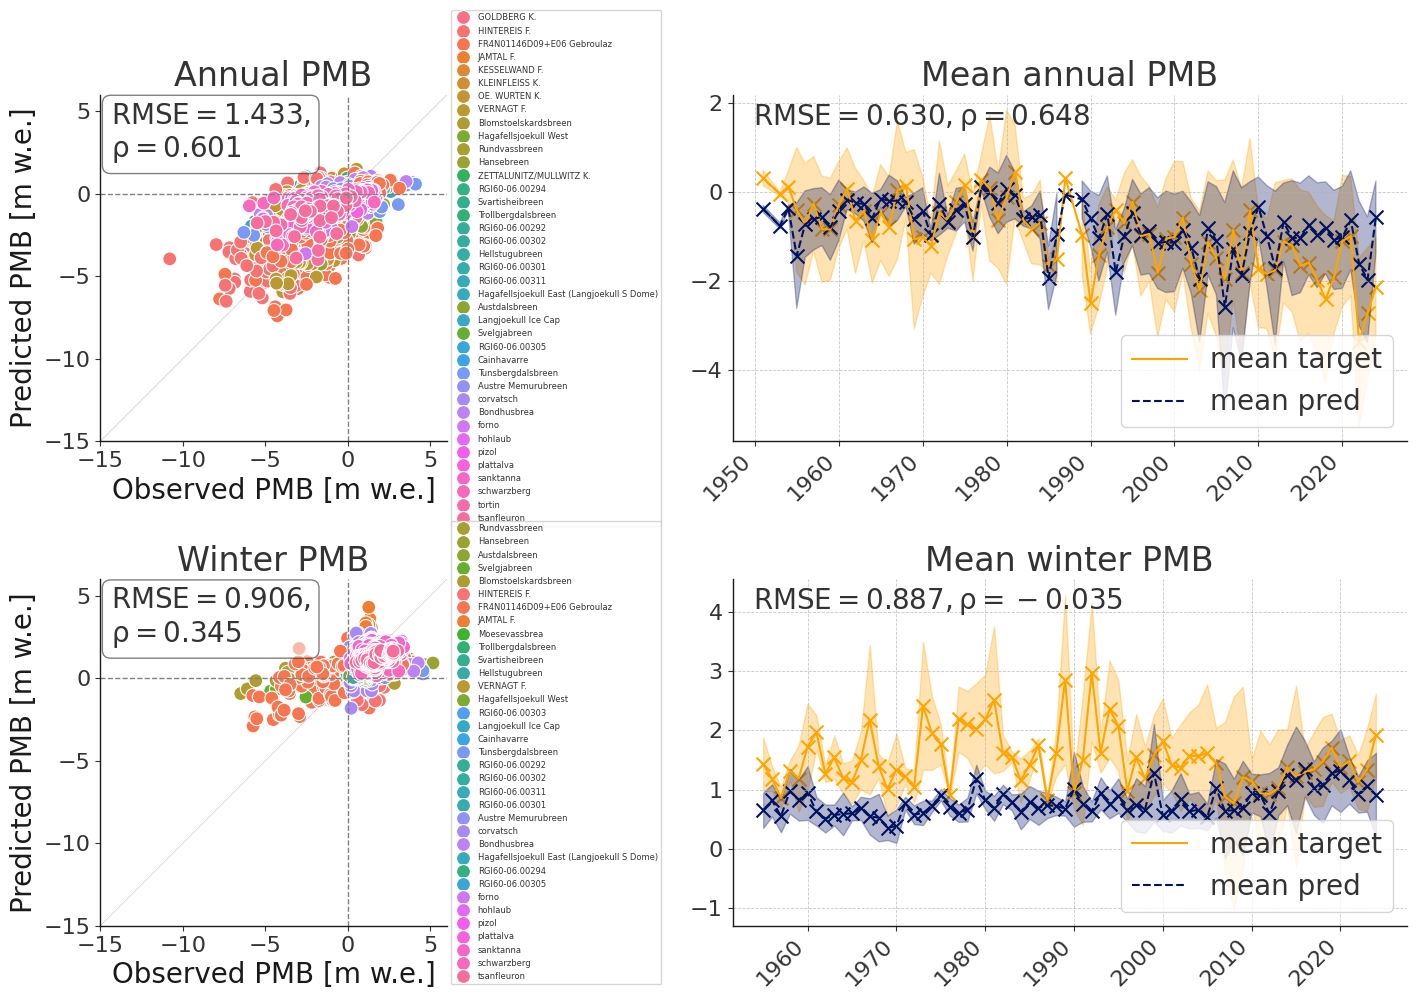

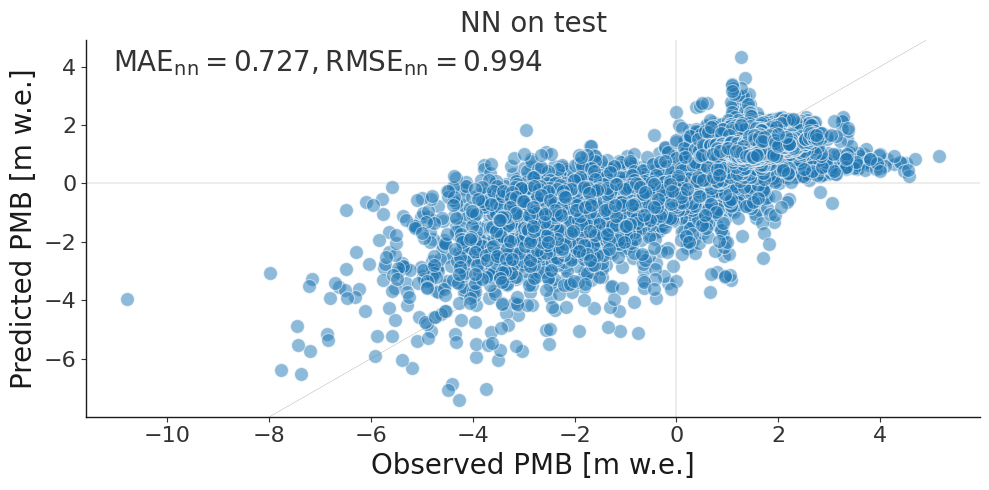

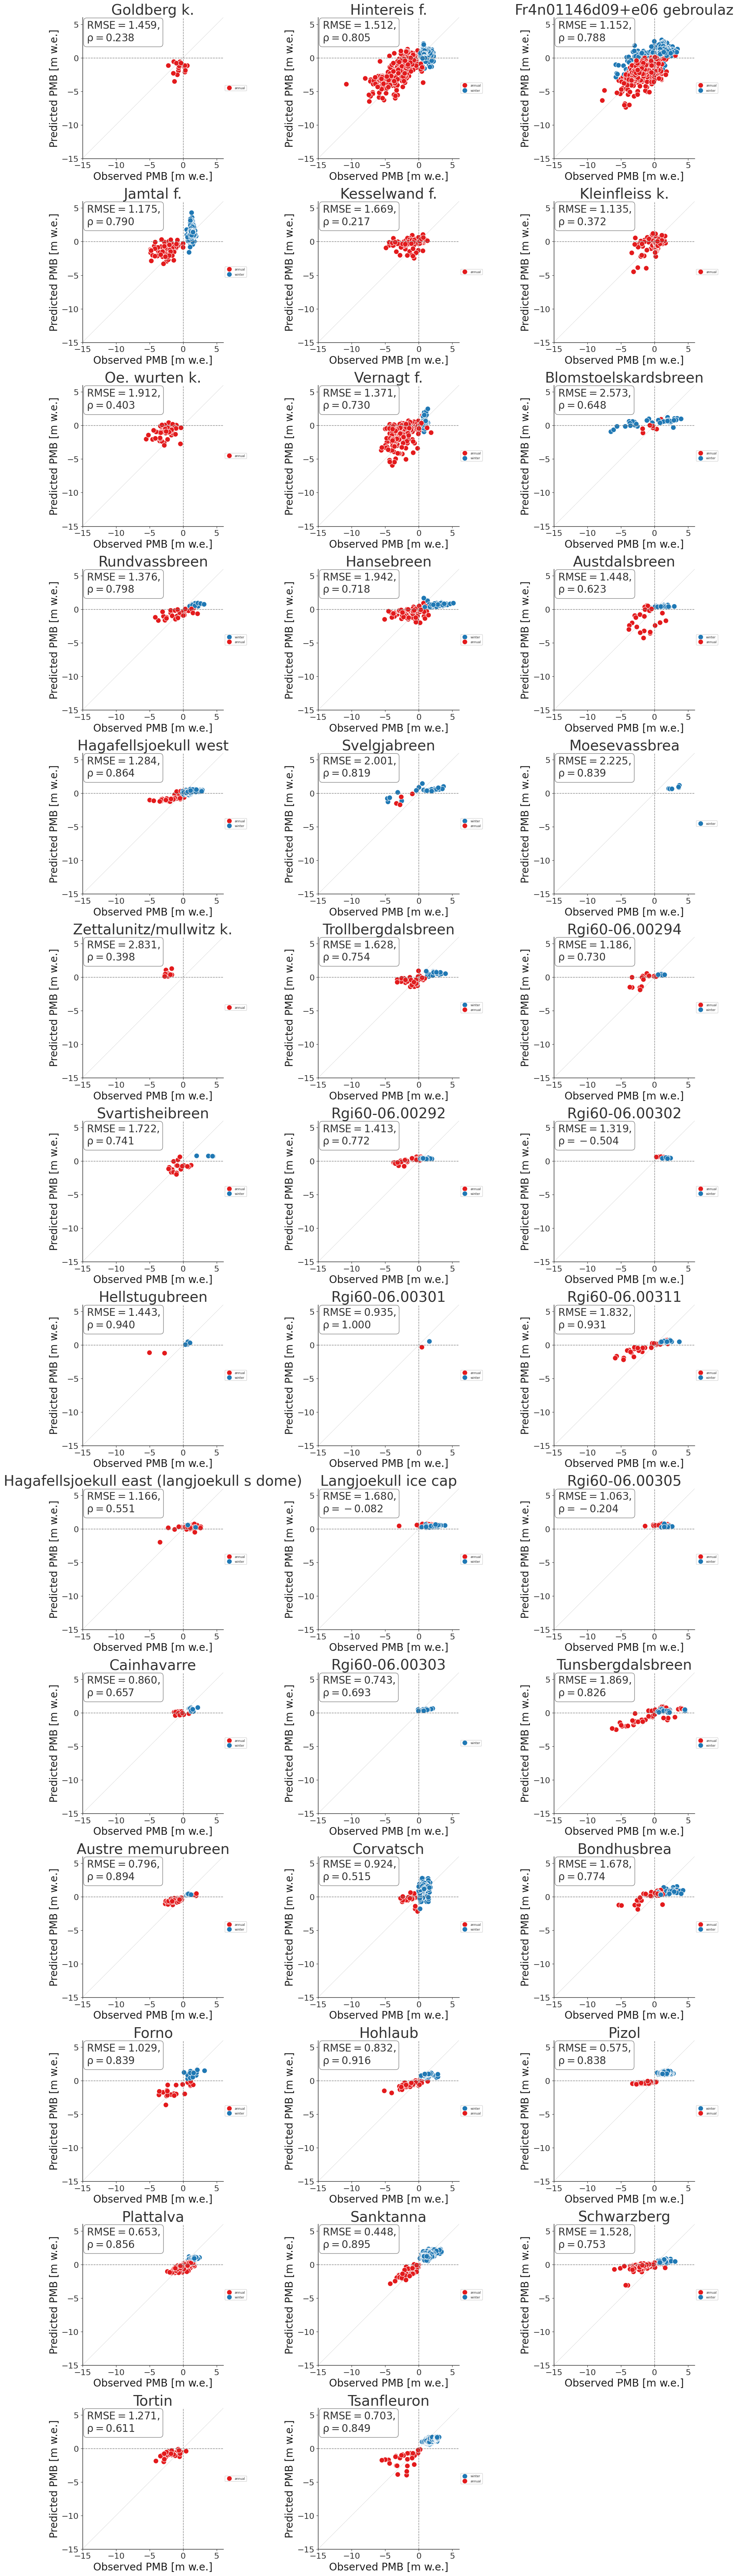

In [16]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))